In [351]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy.special import expit
from scipy.optimize import minimize_scalar

import copy

from numpy.linalg import pinv
from sklearn.datasets import load_iris
from scipy.optimize import fmin_bfgs

import multiprocessing as mp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [223]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [224]:
import math

class Linear:
    def val(x):
        return x
    def dev(x):
        return 1

class TANH:
    def val(x):
        return np.tanh(x)
    def dev(x):
        return 1 - np.tanh(x)*np.tanh(x)

class Sigmoid:
    def val(x):
        return 1 / (1 + np.exp(-x))
    def dev(x):
        return (1 / (1 + np.exp(-x))) * (1-1 / (1 + np.exp(-x)))

class Relu:    
    def val(x):
        return np.maximum(x.copy(),0)
    def dev(x):
        return (x>0).astype(int)

class ArcTan:    
    def val(x):
        return np.arctan(x)
    def dev(x):
        return 1/(x*x+1)
    
class SiLU:
    def val(x):
        return x / (1 + np.exp(-x))
    def dev(x):
        return x / (1 + np.exp(-x)) + (1-x / (1 + np.exp(-x))) / (1 + np.exp(-x))

    
def no_decay(eta,t,epoch):
    return eta

def exp_decay(eta,t,epoch):
    eta = 0.001
    k = 0.001
    lrate = eta * np.exp(-k*t)
    return lrate

def inverse_decay(eta,t,epoch):
    eta = 0.001
    lrate = eta /(1+t/epoch)
    return lrate

So, we can write the cost function in the following fashion.
\begin{equation*}
cost\_ function = f_i(\phi_{i} (M_i \phi_{i-1}(M_{i-1} N_{i-2}+b_{i-1}) + b_i))
\end{equation*}
in which, $f_i$ represents all the afterward layers and the cost function definition, $b_i$ is the bias term for the $i$-th layer, and $N_i$ is the neuron value of the $i$-th layer, $V_i$ is the value before apply the activation function($V_i = M_{i} N_{i-1}+b_{i}$). 

We find that:
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* N_{i-1}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_i} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial b_{i-1}} = f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}*\phi_{i-1}^{'}(V_{i-1})
\end{equation*}
In principle we can also write the third equation as,
\begin{equation*}
\frac{\partial (cost\_ function)}{\partial M_{i-1}} = f_{i-1} ^{'}(N_{i-1})*\phi_{i-1}^{'}(V_{i-1})*N_{i-2}
\end{equation*}
which gives us that
\begin{equation*}
 f_{i-1} ^{'}(N_{i-1})= f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)* M_{i}
\end{equation*}
We can refer $f_i ^{'}(N_{i})$ as the derivative_prefix, and as long as we can keep track of the derivative_prefix in different layers, we can calculate the partial derivative of each layer efficiently.


In [373]:
class Sequential(object):
    def __init__(self, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate = no_decay,
                 early_stopping=False):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.metric = metric
        self.verbose = verbose
        self.regular = regular
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        
        self.dims = []
        self.acts = []
        
        self.matrice = []
        self.bias = []
        self.vects = [] #before the activation function
        self.neurons = [] #after the activation function
        self.dropout = [] #to be implemented later
        self.Y = []
        
        self.loss = []
        
    def add(self,arg,argv):
        '''
        add('Dense',12)
        add('Dense',15)
        add('Activation',Sigmoid)
        add('Activation',Relu)
        add('Dropout',0.5)
        '''
        if arg == 'Dense':
            if len(self.dropout) < len(self.dims):
                self.dropout.append(0)
            if len(self.dims) == 0:
                self.dims.append([0,argv])
            else:
                self.dims.append([self.dims[-1][-1],argv])
        if arg == 'Activation':
            self.acts.append(argv)
        if arg == 'Dropout':
            self.dropout.append(argv)
        return
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_params(self,X,Y):
        for row,col in self.dims:
            W_num_elems = row*col
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(col, row) # reshape to be W
            self.matrice.append(W)
            
            b = np.random.uniform(-1.0, 1.0, size=col)
            b = b.reshape(col, 1)
            self.bias.append(b) #adding bias vector
        
        self.neurons.append(X.T)
        self.Y = self._encode_labels(Y)
        return
    
    def activate(self,vec,act):
        return act.val(vec)
    
    def activate_dev(self,vec,act):
        return act.dev(vec)
    
    def _feedforward(self):
        '''
        clear the previous feedforward result
        '''
        self.neurons = self.neurons[:1]
        self.vects = []
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            self.vects.append(W @ self.neurons[-1] + b)
            self.neurons.append(self.activate(self.vects[-1],act))
        m = self.Y.shape[1]
        if self.cost_function == 'quadratic':
            self.loss.append(((self.neurons[-1]-self.Y)*(self.neurons[-1]-self.Y)).sum()/m)
        elif self.cost_function == 'cross_entropy':
            cost = -(1.0/m) * np.sum(self.Y*np.log(self.neurons[-1]) + (1-self.Y)*np.log(1-self.neurons[-1]))
            self.loss.append(cost)
        return

    def predict(self,X_test):
        neuron = X_test.T
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            vec = W @ neuron + b
            neuron = self.activate(vec,act)
        y_pred = np.argmax(neuron, axis=0)
        return y_pred

    def set_init_dev_prefix(self):
        if self.cost_function == 'quadratic':
            return -2 * (self.Y - self.neurons[-1])
        if self.cost_function == 'cross_entropy':
            return -(self.Y/self.neurons[-1] +(self.Y-1)/(self.neurons[-1]-1))

    def _update_params(self):
        cur_dev_prefix = self.set_init_dev_prefix()
        grads = []
        bias_grads = []
        for N,N1,V,act,W in zip(self.neurons[1:][::-1],self.neurons[:-1][::-1],self.vects[::-1],self.acts[::-1],self.matrice[::-1]):
            cur_dev_prefix *= self.activate_dev(V,act)
            grads.append(cur_dev_prefix @ N1.T)
            bias_grads.append(cur_dev_prefix @ np.full((cur_dev_prefix.shape[1], 1), 1))
            cur_dev_prefix = W.T @ cur_dev_prefix                
        grads.reverse()
        bias_grads.reverse()
        
        if self.regular != 'None':
            for W,b,grad,bias_grad in zip(self.matrice,self.bias,grads,bias_grads):
                if 'L2' in self.regular:
                    grad += 2*self.C * W
                    bias_grad += 2*self.C * b
                if 'L1' in self.regular:
                    grad += ((W>0).astype(int)-0.5)*(2*self.C)
                    bias_grad += self.C *((b>0).astype(int)-0.5)*(2*self.C)
                    
        for W,grad,b,bias_grad in zip(self.matrice,grads,self.bias,bias_grads):
            W -= self.eta * grad
            b -= self.eta * bias_grad
        return
    
    def fit(self,X,Y):
        self.dims[0][0] = X.shape[1]
        if len(np.unique(Y)) != self.dims[-1][-1]:
            print('Error: output dimension is wrong!')
            return False
        self._initialize_params(X,Y)
        #print(self.dims)
        #print([x.shape for x in self.matrice])
        #print([x.shape for x in self.bias])

        for i in range(self.epochs):
            self.eta = self.learning_rate(self.eta,i,self.epochs)
            self._feedforward()
            self._update_params()
            
            if self.verbose and not i % max(1,int(self.epochs/10)):
                if self.metric == 'accuracy':
                    accu = accuracy_score(np.argmax(self.neurons[-1], axis=0),Y)
                print('{} percent finished, current accuracy is {:.3f}.'.format(100*i//self.epochs,accu))
        plt.figure()
        plt.plot([i for i in range(self.epochs-1)],self.loss[1:])
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        print('Training is done!')

0 percent finished, current accuracy is 0.333.
10 percent finished, current accuracy is 0.787.
20 percent finished, current accuracy is 0.900.
30 percent finished, current accuracy is 0.940.
40 percent finished, current accuracy is 0.973.
50 percent finished, current accuracy is 0.973.
60 percent finished, current accuracy is 0.973.
70 percent finished, current accuracy is 0.980.
80 percent finished, current accuracy is 0.980.
90 percent finished, current accuracy is 0.980.
Training is done!


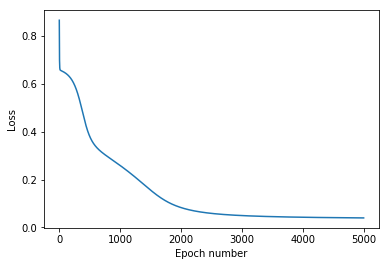

In [386]:
model = Sequential(C=0.1, epochs=5000, eta=0.01, random_state=42, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=inverse_decay)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)

ds = load_iris()
X = ds.data
X_test = StandardScaler().fit(X).transform(X)
X = StandardScaler().fit(X).transform(X)
Y = ds.target # note problem is NOT binary anymore, there are three classes!


model.fit(X,Y)
#print(model.predict(X))
#print(Y)

0 percent finished, current accuracy is 0.523.
10 percent finished, current accuracy is 0.523.
20 percent finished, current accuracy is 0.523.
30 percent finished, current accuracy is 0.523.
40 percent finished, current accuracy is 0.523.
50 percent finished, current accuracy is 0.523.
60 percent finished, current accuracy is 0.523.
70 percent finished, current accuracy is 0.523.
80 percent finished, current accuracy is 0.523.
90 percent finished, current accuracy is 0.523.
Training is done!
[0 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]


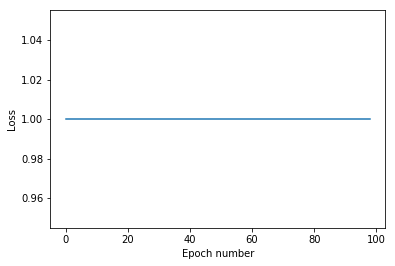

In [389]:
full_df = pd.read_csv('data/processed_data.csv')

Y = full_df['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
data_cols = list(full_df)
data_cols.remove('readmitted')
X = full_df[data_cols].values

model = Sequential(C=0.1, epochs=100, eta=0.01, random_state=42, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate=no_decay)
model.add('Dense',3)
model.add('Activation',Sigmoid)
model.add('Dense',20)
model.add('Activation',Sigmoid)
model.add('Dense',28)
model.add('Activation',Sigmoid)
model.add('Dense',3)
model.add('Activation',Sigmoid)



model.fit(X,Y)
print(model.predict(X))
print(Y)

0 percent finished, current accuracy is 0.090.
10 percent finished, current accuracy is 0.107.
20 percent finished, current accuracy is 0.099.
30 percent finished, current accuracy is 0.101.
40 percent finished, current accuracy is 0.101.
50 percent finished, current accuracy is 0.101.
60 percent finished, current accuracy is 0.101.
70 percent finished, current accuracy is 0.101.
80 percent finished, current accuracy is 0.101.
90 percent finished, current accuracy is 0.101.
Training is done!
[6 6 6 ... 6 6 6]


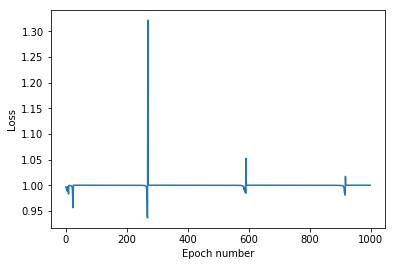

In [407]:
from sklearn.datasets import load_digits

ds = load_digits()
X = ds.data/16.0-0.5
Y = ds.target

model = Sequential(C=0.1, epochs=1000, eta=0.01, random_state=42, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='L1',
                 learning_rate=no_decay)
model.add('Dense',30)
model.add('Activation',Sigmoid)
model.add('Dense',10)
model.add('Activation',Sigmoid)



model.fit(X,Y)

print(model.predict(X))